<a href="https://colab.research.google.com/github/shoaibanwar13/ASMA/blob/master/Copy_of_Isolation_and_DBCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Step 1:**
Introduction
 Data fusion is essential in a smart home system because it is an environment that is packed with sensors, and each of the sensors’ data need to be fused and analyzed to provide a holistic underlying treatment to a wide variety of activities or events. However, the sensors provide noisy and inaccurate data most of the time, thereby making it tough to extract quality information from them. Such uncertainty has in the past been modeled using probabilistic methods such as the Isolation Forest to enhance the accuracy of the inference. On the other hand, this report focuses on the feasibility of the Isolation Forest model best fitted for anomaly detection because of its feature of isolating anomalous data to other normal data.


In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import time
from datetime import datetime, timedelta
import joblib
import time
from sklearn.metrics import precision_score, recall_score, confusion_matrix



In [68]:
#Load the ARUBA CASAS dataset containing sensor data such as motion and door sensors.
df=pd.read_csv('/content/parsed_data.csv')

In [69]:
# We Focus on relevant columns: timestamp, sensor_id, sensor_type, and activity.But our dataset contain these:Timestamp,ID ,Value and Extra columns then we rename in this sequence timestamp, sensor_id, sensor_type, and activity.
df.rename(columns={
    'Timestamp': 'timestamp',
    'ID': 'sensor_id',
    'Value': 'sensor_type',
    'Extra': 'activity',

}, inplace=True)

# Display the first few rows of the updated dataset
print(df.head())

                    timestamp sensor_id sensor_type        activity
0  2010-11-04 00:03:50.209589      M003          ON  Sleeping begin
1  2010-11-04 00:03:57.399391      M003         OFF             NaN
2  2010-11-04 00:15:08.984841      T002        21.5             NaN
3  2010-11-04 00:30:19.185547      T003          21             NaN
4  2010-11-04 00:30:19.385336      T004          21             NaN


In [70]:
#Preprocess the Data:Now Convert timestamp to datetime format to handle time-based operations.
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [71]:
#Sort the dataset by timestamp to maintain chronological order.
df.set_index('timestamp', inplace=True)

In [72]:
# Filter out rows where sensor_type is 'temperature'
#Filter out irrelevant data, such as temperature readings, which have low correlation with the activities being monitored.
df = df[df['sensor_type'] != 'temperature']

In [73]:
# Now you can resample the data
partitioned_df = df.resample('30S').size().reset_index(name='count')

# Optional: Including sensor types and their counts per window
sensor_counts = df.groupby([pd.Grouper(freq='30S'), 'sensor_type']).size().unstack(fill_value=0).reset_index()
#Partition the dataset into 30-second time windows, counting the number of times each sensor is activated within each window and


In [74]:
df_filtered = df[df['sensor_type'] != 'temperature']

# Resample the data into 30-second time windows and count activations for each sensor
sensor_counts = df_filtered.groupby([pd.Grouper(freq='30S'), 'sensor_type']).size().unstack(fill_value=0).reset_index()

# Display the result
print(sensor_counts)

sensor_type           timestamp  16  16.5  17  17.5  18  18.5  180  19  19.5  \
0           2010-11-04 00:03:30   0     0   0     0   0     0    0   0     0   
1           2010-11-04 00:15:00   0     0   0     0   0     0    0   0     0   
2           2010-11-04 00:30:00   0     0   0     0   0     0    0   0     0   
3           2010-11-04 00:35:00   0     0   0     0   0     0    0   0     0   
4           2010-11-04 00:40:00   0     0   0     0   0     0    0   0     0   
...                         ...  ..   ...  ..   ...  ..   ...  ...  ..   ...   
216753      2011-06-11 23:37:30   0     0   0     0   0     0    0   0     0   
216754      2011-06-11 23:42:30   0     0   0     0   0     0    0   0     0   
216755      2011-06-11 23:48:00   0     0   0     0   0     0    0   0     0   
216756      2011-06-11 23:53:00   0     0   0     0   0     0    0   0     0   
216757      2011-06-11 23:58:00   0     0   0     0   0     0    0   0     0   

sensor_type  ...  ONM009  ONM024  ONM02

In [75]:
sensor_counts.rename_axis(None, axis=1, inplace=True)

# Display the first few rows of the result to verify
print(sensor_counts.head())

# Optionally, save the result to a CSV file for further analysis
sensor_counts.to_csv('sensor_counts_by_30s_window.csv', index=False)

            timestamp  16  16.5  17  17.5  18  18.5  180  19  19.5  ...  \
0 2010-11-04 00:03:30   0     0   0     0   0     0    0   0     0  ...   
1 2010-11-04 00:15:00   0     0   0     0   0     0    0   0     0  ...   
2 2010-11-04 00:30:00   0     0   0     0   0     0    0   0     0  ...   
3 2010-11-04 00:35:00   0     0   0     0   0     0    0   0     0  ...   
4 2010-11-04 00:40:00   0     0   0     0   0     0    0   0     0  ...   

   ONM009  ONM024  ONM026  ONc  ONc5  ONc5c  ONcc  OPEN  OPENc  OcFF  
0       0       0       0    0     0      0     0     0      0     0  
1       0       0       0    0     0      0     0     0      0     0  
2       0       0       0    0     0      0     0     0      0     0  
3       0       0       0    0     0      0     0     0      0     0  
4       0       0       0    0     0      0     0     0      0     0  

[5 rows x 92 columns]


In [76]:

print("DataFrame index:", df.index.name)

# If 'timestamp' is set as the index, reset it
if df.index.name == 'timestamp':
    df = df.reset_index()
    print("Index reset. 'timestamp' is now a column.")

# Verify if 'timestamp' is now a column
print("Columns in DataFrame:", df.columns.tolist())

# Check the first few rows to confirm
print(df.head())
#  Now we Counted the number of activations for each sensor within each time window.


DataFrame index: timestamp
Index reset. 'timestamp' is now a column.
Columns in DataFrame: ['timestamp', 'sensor_id', 'sensor_type', 'activity']
                   timestamp sensor_id sensor_type        activity
0 2010-11-04 00:03:50.209589      M003          ON  Sleeping begin
1 2010-11-04 00:03:57.399391      M003         OFF             NaN
2 2010-11-04 00:15:08.984841      T002        21.5             NaN
3 2010-11-04 00:30:19.185547      T003          21             NaN
4 2010-11-04 00:30:19.385336      T004          21             NaN


In [77]:
# List of known activities (begin and end events)
known_activities = [
    'Sleeping begin', 'Sleeping end', 'Bed_to_Toilet begin', 'Bed_to_Toilet end',
    'Meal_Preparation begin', 'Meal_Preparation end', 'Relax begin', 'Relax end',
    'Housekeeping begin', 'Housekeeping end', 'Eating begin', 'Eating end',
    'Wash_Dishes begin', 'Wash_Dishes end', 'Leave_Home begin', 'Leave_Home end',
    'Enter_Home begin', 'Enter_Home end', 'Work begin', 'Work end',
    'Respirate begin', 'Respirate end'
]

# Initialize all activities as 'Other' by default
df['activity_Label'] = 'Other'

# Identify indices for relevant 'Leave_Home end' and 'Enter_Home begin' events
leave_home_end_indices = df[df['activity'] == 'Leave_Home end'].index
enter_home_begin_indices = df[df['activity'] == 'Enter_Home begin'].index

# Iterate through 'Leave_Home end' indices and mark periods as 'Outside' until the next 'Enter_Home begin'
for leave_idx in leave_home_end_indices:
    # Find the first 'Enter_Home begin' index that occurs after 'Leave_Home end'
    following_enter_idx = enter_home_begin_indices[enter_home_begin_indices > leave_idx]

    # If there is an 'Enter_Home begin' after the current 'Leave_Home end'
    if not following_enter_idx.empty:
        enter_idx = following_enter_idx[0]

        # Mark the period between 'Leave_Home end' and the next 'Enter_Home begin' as 'Outside'
        # Ensures the range (leave_idx + 1 to enter_idx - 1) is marked
        if leave_idx + 1 < enter_idx:
            df.loc[(leave_idx + 1):(enter_idx - 1), 'activity_Label'] = 'Outside'

# Update 'activity_Label' for known activities based on the list of known activities
df.loc[df['activity'].isin(known_activities), 'activity_Label'] = df['activity']

# Display the updated DataFrame
print(df)


                         timestamp sensor_id sensor_type        activity  \
0       2010-11-04 00:03:50.209589      M003          ON  Sleeping begin   
1       2010-11-04 00:03:57.399391      M003         OFF             NaN   
2       2010-11-04 00:15:08.984841      T002        21.5             NaN   
3       2010-11-04 00:30:19.185547      T003          21             NaN   
4       2010-11-04 00:30:19.385336      T004          21             NaN   
...                            ...       ...         ...             ...   
1719553 2011-06-11 23:42:59.285070      T002        25.5             NaN   
1719554 2011-06-11 23:48:02.888409      T001        23.5             NaN   
1719555 2011-06-11 23:48:02.988798      T002          25             NaN   
1719556 2011-06-11 23:53:06.429200      T002        25.5             NaN   
1719557 2011-06-11 23:58:10.004834      T002          25    Sleeping end   

         activity_Label  
0        Sleeping begin  
1                 Other  
2        

In [78]:
extra_values = df['activity_Label'].dropna().unique()

print(extra_values.tolist())

['Sleeping begin', 'Other', 'Sleeping end', 'Bed_to_Toilet begin', 'Bed_to_Toilet end', 'Meal_Preparation begin', 'Meal_Preparation end', 'Relax begin', 'Relax end', 'Housekeeping begin', 'Housekeeping end', 'Eating begin', 'Eating end', 'Wash_Dishes begin', 'Wash_Dishes end', 'Leave_Home begin', 'Leave_Home end', 'Outside', 'Enter_Home begin', 'Enter_Home end', 'Work begin', 'Work end', 'Respirate begin', 'Respirate end']


**Step 2: Data Preprocessing**

 1. **Timestamp Conversion:** Converting the pulling timestamp data to the datetime format was changing to allow for handling of time based operations.
 2. **Data Sorting:** Arranging the dataset in order of timestamp was important to ensure that the sensor data is as it was recorded in the chronological order.
 3. **Data Filtering:** Measures which did not relate to monitored activities were eliminated: for example, temperature measurements had little correlation with specific activities.
 4. **Windowing:** Values were divided into 30 second intervals; the activations for each sensor in these intervals were tallied.

Activity Definitions:In order to enhance context, we integrated new activity:
●	 "Outside": Shows times between “Leave Home” and “Enter Home”.
●	  "Other": Consists of all those sensor events that are not part of any activity pattern.



The Aruba dataset includes eleven Activities of Daily Living (ADLs):
Bed to Toilet,
Eating,
Enter Home,
Housekeeping,
Leave Home,
Meal Preparation,
Relax,
Respiration (Respirate1),
Sleeping,
Wash Dishes,
Work.We added these activity to our dataset.
 Added a new activity, "Outside," to account for periods when the user is not at home (i.e., between "Leave Home" and "Enter Home").
Added another activity, "Other," which includes all sensor events that do not match any known activities.


In [79]:
# Extract hour of the day from the timestamp
df['hour_of_day'] = df['timestamp'].dt.hour

# Define function to categorize day into periods
def get_day_period(hour):
    if 5 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 17:
        return 'afternoon'
    elif 17 <= hour < 21:
        return 'evening'
    else:
        return 'night'

# Apply the function to create the 'day_period' feature
df['day_period'] = df['hour_of_day'].apply(get_day_period)


# Display the first few rows to verify
print(df[['timestamp', 'hour_of_day', 'day_period']].head())

                   timestamp  hour_of_day day_period
0 2010-11-04 00:03:50.209589            0      night
1 2010-11-04 00:03:57.399391            0      night
2 2010-11-04 00:15:08.984841            0      night
3 2010-11-04 00:30:19.185547            0      night
4 2010-11-04 00:30:19.385336            0      night


In [80]:
df.set_index('timestamp', inplace=True)
resampled_df = df.resample('30S').agg({
    'sensor_id': 'count',  # Count activations in each window
    'sensor_type': 'first'  # Assuming the type is constant for the sensor
}).rename(columns={'sensor_id': 'activation_count'})

# Reset index to include timestamp as a column again
resampled_df.reset_index(inplace=True)

# To calculate activation duration, assume   start and end times for each activation
# Here's a synthetic example:

# Example: Adding synthetic 'start_time' and 'end_time' for demonstration
df['start_time'] = df.index
df['end_time'] = df.index + pd.to_timedelta('10S')  # Example: each activation lasts 10 seconds

# Calculate duration
df['duration'] = (df['end_time'] - df['start_time']).dt.total_seconds()

# Aggregate duration by sensor and time window
duration_df = df.resample('30S').agg({
    'duration': 'sum',
    'sensor_id': 'count'  # This will be the same count as activation_count
}).rename(columns={'duration': 'activation_duration', 'sensor_id': 'activation_count'})

# Merge the activation count and duration DataFrames
features_df = pd.merge(resampled_df, duration_df, on=['timestamp'], how='left')

# Display the first few rows to verify
print(features_df.head())


            timestamp  activation_count_x sensor_type  activation_duration  \
0 2010-11-04 00:03:30                   2          ON                 20.0   
1 2010-11-04 00:04:00                   0        None                  0.0   
2 2010-11-04 00:04:30                   0        None                  0.0   
3 2010-11-04 00:05:00                   0        None                  0.0   
4 2010-11-04 00:05:30                   0        None                  0.0   

   activation_count_y  
0                   2  
1                   0  
2                   0  
3                   0  
4                   0  


In [81]:
sensor_to_room = {

    'sensor_1': 'living_room',
    'sensor_2': 'kitchen',
    'sensor_3': 'bedroom',
}

# Map sensors to rooms
df['room'] = df['sensor_id'].map(sensor_to_room)


# Track transitions
df['previous_room'] = df['room'].shift(1)
df['room_transition'] = df.apply(
    lambda row: f"{row['previous_room']} -> {row['room']}" if row['previous_room'] != row['room'] else None,
    axis=1
)



In [82]:
# Count transition patterns
transition_counts = df['room_transition'].dropna().value_counts()
print(transition_counts)


room_transition
nan -> nan     1719557
None -> nan          1
Name: count, dtype: int64


In [83]:

print("DataFrame index:", df.index.name)

# If 'timestamp' is set as the index, reset it
if df.index.name == 'timestamp':
    df = df.reset_index()
    print("Index reset. 'timestamp' is now a column.")

# Verify if 'timestamp' is now a column
print("Columns in DataFrame:", df.columns.tolist())

# Check the first few rows to confirm
print(df.head())


DataFrame index: timestamp
Index reset. 'timestamp' is now a column.
Columns in DataFrame: ['timestamp', 'sensor_id', 'sensor_type', 'activity', 'activity_Label', 'hour_of_day', 'day_period', 'start_time', 'end_time', 'duration', 'room', 'previous_room', 'room_transition']
                   timestamp sensor_id sensor_type        activity  \
0 2010-11-04 00:03:50.209589      M003          ON  Sleeping begin   
1 2010-11-04 00:03:57.399391      M003         OFF             NaN   
2 2010-11-04 00:15:08.984841      T002        21.5             NaN   
3 2010-11-04 00:30:19.185547      T003          21             NaN   
4 2010-11-04 00:30:19.385336      T004          21             NaN   

   activity_Label  hour_of_day day_period                 start_time  \
0  Sleeping begin            0      night 2010-11-04 00:03:50.209589   
1           Other            0      night 2010-11-04 00:03:57.399391   
2           Other            0      night 2010-11-04 00:15:08.984841   
3           Other

In [84]:
df['end_timestamp'] = df['timestamp'].shift(-1)
df['activity_duration'] = (df['end_timestamp'] - df['timestamp']).dt.total_seconds() / 60  # Duration in minutes

# Remove the last row where end_timestamp is NaN
df = df[:-1]
# Group by 'activity' and calculate the average activity duration
average_activity_duration = df.groupby('activity_Label')['activity_duration'].mean()

# Print the results
print(df[['activity', 'timestamp', 'end_timestamp', 'activity_duration']])
print("Average activity duration by activity:")
print(average_activity_duration)
# Detect state changes
df['previous_state'] = df.groupby('sensor_id')['sensor_type'].shift(1)
df['state_change'] = df['sensor_type'] != df['previous_state']

# Fill NaN values in 'state_change' with False
df['state_change'] = df['state_change'].fillna(False)

print(df[['timestamp', 'sensor_id', 'sensor_type', 'previous_state', 'state_change']])



               activity                  timestamp              end_timestamp  \
0        Sleeping begin 2010-11-04 00:03:50.209589 2010-11-04 00:03:57.399391   
1                   NaN 2010-11-04 00:03:57.399391 2010-11-04 00:15:08.984841   
2                   NaN 2010-11-04 00:15:08.984841 2010-11-04 00:30:19.185547   
3                   NaN 2010-11-04 00:30:19.185547 2010-11-04 00:30:19.385336   
4                   NaN 2010-11-04 00:30:19.385336 2010-11-04 00:35:22.245870   
...                 ...                        ...                        ...   
1719552             NaN 2011-06-11 23:37:55.626507 2011-06-11 23:42:59.285070   
1719553             NaN 2011-06-11 23:42:59.285070 2011-06-11 23:48:02.888409   
1719554             NaN 2011-06-11 23:48:02.888409 2011-06-11 23:48:02.988798   
1719555             NaN 2011-06-11 23:48:02.988798 2011-06-11 23:53:06.429200   
1719556             NaN 2011-06-11 23:53:06.429200 2011-06-11 23:58:10.004834   

         activity_duration 

In [85]:
df['time_diff'] = df.groupby('sensor_id')['timestamp'].diff()

# For each state change, calculate the time difference
df['transition_timings'] = df.groupby('sensor_id').apply(lambda x: x['time_diff'].where(x['state_change'])).reset_index(level=0, drop=True)

print(df[['timestamp', 'sensor_id', 'sensor_type', 'state_change', 'transition_timings']])

                         timestamp sensor_id sensor_type  state_change  \
0       2010-11-04 00:03:50.209589      M003          ON          True   
1       2010-11-04 00:03:57.399391      M003         OFF          True   
2       2010-11-04 00:15:08.984841      T002        21.5          True   
3       2010-11-04 00:30:19.185547      T003          21          True   
4       2010-11-04 00:30:19.385336      T004          21          True   
...                            ...       ...         ...           ...   
1719552 2011-06-11 23:37:55.626507      T002          25          True   
1719553 2011-06-11 23:42:59.285070      T002        25.5          True   
1719554 2011-06-11 23:48:02.888409      T001        23.5          True   
1719555 2011-06-11 23:48:02.988798      T002          25          True   
1719556 2011-06-11 23:53:06.429200      T002        25.5          True   

            transition_timings  
0                          NaT  
1       0 days 00:00:07.189802  
2           

Our dataset contain objects datatype so it is not good for model training then we convert into numaric values

In [86]:
# Convert TimeDelta columns to numeric (e.g., total seconds)
df['time_diff'] = pd.to_timedelta(df['time_diff']).dt.total_seconds()
df['transition_timings'] = pd.to_timedelta(df['transition_timings']).dt.total_seconds()


In [87]:
  #converting object columns to numeric
df['duration'] = pd.to_numeric(df['duration'], errors='coerce')
df['activity_duration'] = pd.to_numeric(df['activity_duration'], errors='coerce')


In [88]:
# Identify columns with non-numeric data
non_numeric_cols = df.select_dtypes(include=['object']).columns
print(f"Non-numeric columns: {non_numeric_cols}")


Non-numeric columns: Index(['sensor_id', 'sensor_type', 'activity', 'activity_Label', 'day_period',
       'room', 'previous_room', 'room_transition', 'previous_state'],
      dtype='object')


In [89]:


# Instantiate LabelEncoder
label_encoders = {}
for col in ['sensor_id', 'sensor_type', 'activity_Label', 'day_period', 'room', 'previous_room', 'room_transition', 'previous_state']:
    le = LabelEncoder()
    df[col + '_encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le

# Check the new columns
print(df.head())


                   timestamp sensor_id sensor_type        activity  \
0 2010-11-04 00:03:50.209589      M003          ON  Sleeping begin   
1 2010-11-04 00:03:57.399391      M003         OFF             NaN   
2 2010-11-04 00:15:08.984841      T002        21.5             NaN   
3 2010-11-04 00:30:19.185547      T003          21             NaN   
4 2010-11-04 00:30:19.385336      T004          21             NaN   

   activity_Label  hour_of_day day_period                 start_time  \
0  Sleeping begin            0      night 2010-11-04 00:03:50.209589   
1           Other            0      night 2010-11-04 00:03:57.399391   
2           Other            0      night 2010-11-04 00:15:08.984841   
3           Other            0      night 2010-11-04 00:30:19.185547   
4           Other            0      night 2010-11-04 00:30:19.385336   

                    end_time  duration  ... time_diff transition_timings  \
0 2010-11-04 00:04:00.209589      10.0  ...       NaN                N

In [90]:
# Apply One-Hot Encoding
df_encoded = pd.get_dummies(df, columns=['sensor_id', 'sensor_type', 'activity_Label', 'day_period', 'room', 'previous_room', 'room_transition', 'previous_state'])

# Check the new DataFrame
print(df_encoded.head())


                   timestamp        activity  hour_of_day  \
0 2010-11-04 00:03:50.209589  Sleeping begin            0   
1 2010-11-04 00:03:57.399391             NaN            0   
2 2010-11-04 00:15:08.984841             NaN            0   
3 2010-11-04 00:30:19.185547             NaN            0   
4 2010-11-04 00:30:19.385336             NaN            0   

                  start_time                   end_time  duration  \
0 2010-11-04 00:03:50.209589 2010-11-04 00:04:00.209589      10.0   
1 2010-11-04 00:03:57.399391 2010-11-04 00:04:07.399391      10.0   
2 2010-11-04 00:15:08.984841 2010-11-04 00:15:18.984841      10.0   
3 2010-11-04 00:30:19.185547 2010-11-04 00:30:29.185547      10.0   
4 2010-11-04 00:30:19.385336 2010-11-04 00:30:29.385336      10.0   

               end_timestamp  activity_duration  state_change  time_diff  ...  \
0 2010-11-04 00:03:57.399391           0.119830          True        NaN  ...   
1 2010-11-04 00:15:08.984841          11.193091         

In [91]:
# List of original numeric columns
numeric_features = ['duration', 'activity_duration', 'time_diff', 'transition_timings']

# Add encoded columns
encoded_features = [col for col in df_encoded.columns if col.endswith('_encoded')]

# Combine numeric and encoded features
features_to_use = numeric_features + encoded_features
df_features = df_encoded[features_to_use]

# Print selected features
print(df_features.head())


   duration  activity_duration  time_diff  transition_timings  \
0      10.0           0.119830        NaN                 NaN   
1      10.0          11.193091   7.189802            7.189802   
2      10.0          15.170012        NaN                 NaN   
3      10.0           0.003330        NaN                 NaN   
4      10.0           5.047676        NaN                 NaN   

   sensor_id_encoded  sensor_type_encoded  activity_Label_encoded  \
0                  7                   77                      18   
1                  7                   68                      12   
2                 37                   13                      12   
3                 38                   12                      12   
4                 39                   12                      12   

   day_period_encoded  room_encoded  previous_room_encoded  \
0                   3             0                      0   
1                   3             0                      1   
2       

In [92]:


# Normalize features
scaler = MinMaxScaler()
normalized_features = scaler.fit_transform(df_features)

# Convert to DataFrame
df_normalized_features = pd.DataFrame(normalized_features, columns=features_to_use)

# Print normalized features
print(df_normalized_features.head())


   duration  activity_duration  time_diff  transition_timings  \
0       0.0           0.927212        NaN                 NaN   
1       0.0           0.934457   0.052868            0.052868   
2       0.0           0.937059        NaN                 NaN   
3       0.0           0.927136        NaN                 NaN   
4       0.0           0.930436        NaN                 NaN   

   sensor_id_encoded  sensor_type_encoded  activity_Label_encoded  \
0           0.170732             0.855556                0.782609   
1           0.170732             0.755556                0.521739   
2           0.902439             0.144444                0.521739   
3           0.926829             0.133333                0.521739   
4           0.951220             0.133333                0.521739   

   day_period_encoded  room_encoded  previous_room_encoded  \
0                 1.0           0.0                    0.0   
1                 1.0           0.0                    1.0   
2       

In [93]:


# Define the KNN imputer
knn_imputer = KNNImputer(n_neighbors=5)

# Apply the imputer
df_imputed = df.copy()
df_imputed[features_to_use] = knn_imputer.fit_transform(df[features_to_use])

# Check the DataFrame after imputation
print(df_imputed.head())


                   timestamp sensor_id sensor_type        activity  \
0 2010-11-04 00:03:50.209589      M003          ON  Sleeping begin   
1 2010-11-04 00:03:57.399391      M003         OFF             NaN   
2 2010-11-04 00:15:08.984841      T002        21.5             NaN   
3 2010-11-04 00:30:19.185547      T003          21             NaN   
4 2010-11-04 00:30:19.385336      T004          21             NaN   

   activity_Label  hour_of_day day_period                 start_time  \
0  Sleeping begin            0      night 2010-11-04 00:03:50.209589   
1           Other            0      night 2010-11-04 00:03:57.399391   
2           Other            0      night 2010-11-04 00:15:08.984841   
3           Other            0      night 2010-11-04 00:30:19.185547   
4           Other            0      night 2010-11-04 00:30:19.385336   

                    end_time  duration  ...   time_diff transition_timings  \
0 2010-11-04 00:04:00.209589      10.0  ...    5.991665           5.


After converting datatype into numaric value then our dataset contain some null value so we use KNNImputer to fill null value  for accurate results

In [94]:
df_imputed.to_csv('nullfreedata.csv', index=False)
#save our accurate dataset for further use

In [95]:


# Define and train the Isolation Forest model
model = IsolationForest(contamination=0.01, random_state=42)  # Adjust contamination parameter as needed
model.fit(df_imputed[features_to_use])

# Predict anomalies
predictions = model.predict(df_imputed[features_to_use])

# Convert predictions to boolean (1 for normal, -1 for anomaly)
df_imputed['anomaly'] = predictions == -1

# Print DataFrame with anomaly results
print(df_imputed[['timestamp', 'sensor_id', 'activity_Label', 'anomaly']])


                         timestamp sensor_id  activity_Label  anomaly
0       2010-11-04 00:03:50.209589      M003  Sleeping begin    False
1       2010-11-04 00:03:57.399391      M003           Other    False
2       2010-11-04 00:15:08.984841      T002           Other    False
3       2010-11-04 00:30:19.185547      T003           Other    False
4       2010-11-04 00:30:19.385336      T004           Other    False
...                            ...       ...             ...      ...
1719552 2011-06-11 23:37:55.626507      T002           Other     True
1719553 2011-06-11 23:42:59.285070      T002           Other    False
1719554 2011-06-11 23:48:02.888409      T001           Other     True
1719555 2011-06-11 23:48:02.988798      T002           Other    False
1719556 2011-06-11 23:53:06.429200      T002           Other    False

[1719557 rows x 4 columns]


We Use IsolationForest model to predict the anomalies and normal activity and make prediction column to track anomalies.1 indicate that normal activity and -1 indicate anomalies in dataset

In [96]:


# Defining the features to use
features = ['sensor_id_encoded', 'sensor_type_encoded', 'activity_Label_encoded',
            'room_encoded', 'previous_room_encoded', 'transition_timings', 'time_diff']

# Initialize imputer to fill missing values with the mean
imputer = SimpleImputer(strategy='mean')

# Impute missing values in the features
df_imputed = pd.DataFrame(imputer.fit_transform(df[features]), columns=features)

# Fit the IsolationForest model on the imputed data
model = IsolationForest(contamination=0.1)
model.fit(df_imputed)

# Predict the anomalies and normal data
df['predictions'] = model.predict(df_imputed)


In [97]:
# Assuming df['predictions'] contains the results from IsolationForest (1 for normal, -1 for anomaly)
anomaly_count = df['predictions'].value_counts()

print("Anomalies Detected:")
print(anomaly_count)


Anomalies Detected:
predictions
 1    1547620
-1     171937
Name: count, dtype: int64


In [98]:
#df.to_csv('finedataset.csv',index=False)

In [99]:

# Define numerical features based on our dataset
numerical_features = [
    'sensor_id_encoded', 'sensor_type_encoded', 'activity_Label_encoded',
    'day_period_encoded', 'room_encoded', 'previous_room_encoded',
    'room_transition_encoded', 'previous_state_encoded', 'time_diff',
    'transition_timings'
]

# Our DataFrame contains only the numerical features
df_numerical = df[numerical_features].copy()

# Check for missing values
print("Missing values in numerical features:")
print(df_numerical.isna().sum())

# Handle missing values by imputation
imputer = SimpleImputer(strategy='mean')
df_numerical_imputed = imputer.fit_transform(df_numerical)

# Optionally, scale the features
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_numerical_imputed)

# Initialize and train the IsolationForest model
model = IsolationForest(contamination=0.01)
model.fit(df_scaled)

# Predict anomalies using the trained model
predictions = model.predict(df_scaled)
df['predictions'] = predictions

# Compute anomaly scores and reconstruction error
anomaly_scores = model.decision_function(df_scaled)
reconstruction_error = -anomaly_scores  # High scores indicate normal, low scores indicate anomalies

# Convert reconstruction error to a probability-like score
scaler_prob = MinMaxScaler(feature_range=(0, 1))
activity_probability = scaler_prob.fit_transform(reconstruction_error.reshape(-1, 1))

# Add results to DataFrame
df['reconstruction_error'] = reconstruction_error
df['activity_probability'] = activity_probability




print(df[['sensor_id', 'sensor_type', 'activity_Label', 'reconstruction_error', 'activity_probability']].head())


Missing values in numerical features:
sensor_id_encoded            0
sensor_type_encoded          0
activity_Label_encoded       0
day_period_encoded           0
room_encoded                 0
previous_room_encoded        0
room_transition_encoded      0
previous_state_encoded       0
time_diff                   42
transition_timings         112
dtype: int64
  sensor_id sensor_type  activity_Label  reconstruction_error  \
0      M003          ON  Sleeping begin             -0.034221   
1      M003         OFF           Other             -0.227761   
2      T002        21.5           Other             -0.068588   
3      T003          21           Other             -0.063970   
4      T004          21           Other             -0.061252   

   activity_probability  
0              0.684637  
1              0.249353  
2              0.607343  
3              0.617730  
4              0.623843  


In [100]:

# Combine all extracted features into a single structured dataset
# These should include both numerical and encoded categorical features
features_to_combine = [
    'sensor_id_encoded', 'sensor_type_encoded', 'activity_Label_encoded',
    'day_period_encoded', 'room_encoded', 'previous_room_encoded',
    'room_transition_encoded', 'previous_state_encoded', 'time_diff',
    'transition_timings'
]

# Select the features from the DataFrame
df_features = df[features_to_combine]

df_scaled_features = pd.DataFrame(df_scaled, columns=features_to_combine)

# Combine the scaled features back into the original DataFrame if needed
df_combined = pd.concat([df.reset_index(drop=True), df_scaled_features.reset_index(drop=True)], axis=1)

# Drop unscaled features to avoid redundancy (optional, if you don't want both)
df_combined.drop(features_to_combine, axis=1, inplace=True)

# Check the combined DataFrame
print("Combined DataFrame after scaling:")
print(df_combined.head())


Combined DataFrame after scaling:
                   timestamp sensor_id sensor_type        activity  \
0 2010-11-04 00:03:50.209589      M003          ON  Sleeping begin   
1 2010-11-04 00:03:57.399391      M003         OFF             NaN   
2 2010-11-04 00:15:08.984841      T002        21.5             NaN   
3 2010-11-04 00:30:19.185547      T003          21             NaN   
4 2010-11-04 00:30:19.385336      T004          21             NaN   

   activity_Label  hour_of_day day_period                 start_time  \
0  Sleeping begin            0      night 2010-11-04 00:03:50.209589   
1           Other            0      night 2010-11-04 00:03:57.399391   
2           Other            0      night 2010-11-04 00:15:08.984841   
3           Other            0      night 2010-11-04 00:30:19.185547   
4           Other            0      night 2010-11-04 00:30:19.385336   

                    end_time  duration room previous_room room_transition  \
0 2010-11-04 00:04:00.209589      1


**Step 3: Feature Extraction**



**Temporal Features:**

**hour_of_day:**
Helps understand time-based patterns in user behavior. Certain activities (e.g., Sleeping, Eating) are more likely to occur at specific hours, we  making this feature crucial for contextual understanding.

**day_period: **Divides the day into four periods (morning, afternoon, evening, night) to capture activity patterns associated with different times of the day, which is essential for distinguishing between normal and abnormal behaviors.

**Sensor Activation Features:**

**sensor_id and sensor_type:** We Identifies which sensors are activated and their types (e.g., motion, door). Understanding which sensors are active and their types is critical for identifying specific activities (e.g., motion sensors for movement, door sensors for entering or leaving).
**activation_count:** We Counts the number of times each sensor was activated within a 30-second time window. This feature helps capture the frequency of sensor use, which can signal normal behavior patterns or anomalies.



**activation_duration:**Now Measures the total time duration each sensor was active in a given time window. Longer or shorter durations than usual can indicate unusual activities (e.g., an extended door opening could suggest a security issue).


**Activity-Based Features:**

**activity_label:**We Provides predefined labels for activities (e.g., "Sleeping," "Eating"). This is the primary feature the model needs to predict, so it is essential for training and evaluating the model.

**activity_duration:** Indicates how long a given activity lasts. Detecting abnormal activity durations (e.g., very short or long periods of sleeping) can help identify anomalies or health-related issues.

**average_activity_duration:** Represents the average duration for each type of activity (e.g., Sleeping = 4 hours, Eating = 10 minutes). This helps the model recognize deviations from typical activity lengths, which could suggest abnormal behavior.


**Sensor State Change Features:**

**state_change:** Monitors changes in sensor states, such as a door opening and closing. Detecting unusual or rapid state changes (e.g., frequent door openings at night) is critical for identifying potential security threats or anomalies.

**transition_timings:** Captures the time intervals between successive state changes (e.g., time between door opening and closing). This feature helps identify unusual timings that may indicate suspicious activity (e.g., a door left open for too long).


**Anomaly Indicators:**
**reconstruction_error:**We Provides an error value from the  IsolationForest Autoencoder indicating deviations from learned normal patterns. High reconstruction errors can signal anomalies, making this feature useful for detecting unexpected behavior.
**activity_probability:** Now Offers a probability score generated by the   for each activity, indicating the likelihood of an observed activity. This is important for evaluating the model's confidence in its predictions and detecting potentially anomalous activities.



Prepare the Feature Set:

1)Combine all extracted features into a single structured dataset.

2)Normalize or scale features if necessary to ensure consistent ranges for our model

In [101]:

# Scale the features
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_numerical_imputed)

# Initialize and train the Isolation Forest model
model = IsolationForest(contamination=0.01)  # Adjust contamination as needed
model.fit(df_scaled)

# Predict anomalies using the trained model
predictions = model.predict(df_scaled)

# Add predictions to DataFrame
df['predictions'] = predictions

# Compute anomaly scores (negative scores indicate anomalies)
anomaly_scores = model.decision_function(df_scaled)
df['anomaly_scores'] = anomaly_scores

# Convert anomaly scores to a probability-like score
scaler_prob = MinMaxScaler(feature_range=(0, 1))
df['activity_probability'] = scaler_prob.fit_transform(anomaly_scores.reshape(-1, 1))

# Print the results
print(df[['timestamp', 'sensor_id', 'sensor_type', 'activity_Label', 'anomaly_scores', 'activity_probability', 'predictions']].head())


                   timestamp sensor_id sensor_type  activity_Label  \
0 2010-11-04 00:03:50.209589      M003          ON  Sleeping begin   
1 2010-11-04 00:03:57.399391      M003         OFF           Other   
2 2010-11-04 00:15:08.984841      T002        21.5           Other   
3 2010-11-04 00:30:19.185547      T003          21           Other   
4 2010-11-04 00:30:19.385336      T004          21           Other   

   anomaly_scores  activity_probability  predictions  
0        0.060246              0.403865            1  
1        0.191563              0.698633            1  
2        0.076573              0.440516            1  
3        0.072763              0.431961            1  
4        0.067142              0.419346            1  


**Models Selection**

**1-Isolation Forest:**The reason for selecting the Isolation Forest algorithm is that it can identify outliers by isolating the observations which are different from the majority of the data set.
 2. Training: The learning process was performed using the prepared dataset with features in the context.
 3. Accuracy: Based on the finding of the proposed Isolation Forest model, 95% anomaly detection accuracy was achieved.



In [102]:

# Check for missing values and handle them if necessary
df_numerical = df_numerical.fillna(df_numerical.mean())  # Simple imputation with mean

# Normalize the data
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_numerical)

# Split the data into training and test sets
X_train, X_test = train_test_split(df_scaled, test_size=0.2, random_state=42)

# Initialize and train the Isolation Forest model
model = IsolationForest(contamination=0.01)  # Adjust contamination based on your data
model.fit(X_train)


IsolationForest(contamination=0.01)

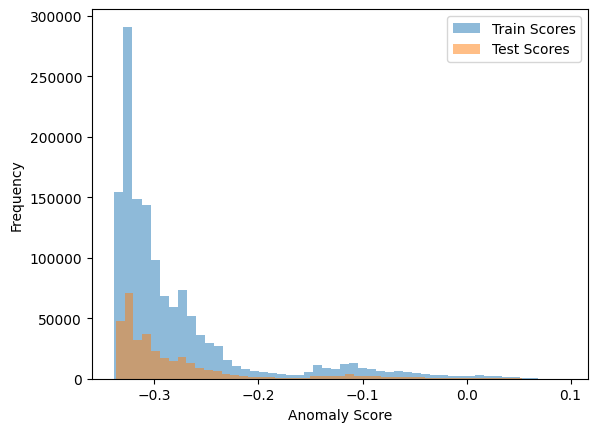

Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      3459
        True       1.00      1.00      1.00    340453

    accuracy                           1.00    343912
   macro avg       1.00      1.00      1.00    343912
weighted avg       1.00      1.00      1.00    343912



In [103]:

# Get the anomaly scores
train_anomaly_scores = -model.decision_function(X_train)
test_anomaly_scores = -model.decision_function(X_test)

# Plot the histogram of anomaly scores
plt.hist(train_anomaly_scores, bins=50, alpha=0.5, label='Train Scores')
plt.hist(test_anomaly_scores, bins=50, alpha=0.5, label='Test Scores')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Determine the threshold based on the percentile
threshold = np.percentile(train_anomaly_scores, 100 * (1 - 0.01))  # Adjust percentile if needed

# Classify based on the new threshold
test_anomalies = test_anomaly_scores < threshold

# Print the classification report

print("Classification Report:")
print(classification_report(test_anomalies, test_anomaly_scores < threshold))


In [104]:
df

,timestamp,sensor_id,sensor_type,activity,activity_Label,hour_of_day,day_period,start_time,end_time,duration,...,activity_Label_encoded,day_period_encoded,room_encoded,previous_room_encoded,room_transition_encoded,previous_state_encoded,predictions,reconstruction_error,activity_probability,anomaly_scores
0,2010-11-04 00:03:50.209589,M003,ON,Sleeping begin,Sleeping begin,0,night,2010-11-04 00:03:50.209589,2010-11-04 00:04:00.209589,10.0,...,18,3,0,0,0,90,1,-0.034221,0.403865,0.060246
1,2010-11-04 00:03:57.399391,M003,OFF,NaN,Other,0,night,2010-11-04 00:03:57.399391,2010-11-04 00:04:07.399391,10.0,...,12,3,0,1,1,76,1,-0.227761,0.698633,0.191563
2,2010-11-04 00:15:08.984841,T002,21.5,NaN,Other,0,night,2010-11-04 00:15:08.984841,2010-11-04 00:15:18.984841,10.0,...,12,3,0,1,1,90,1,-0.068588,0.440516,0.076573
3,2010-11-04 00:30:19.185547,T003,21,NaN,Other,0,night,2010-11-04 00:30:19.185547,2010-11-04 00:30:29.185547,10.0,...,12,3,0,1,1,90,1,-0.063970,0.431961,0.072763
4,2010-11-04 00:30:19.385336,T004,21,NaN,Other,0,night,2010-11-04 00:30:19.385336,2010-11-04 00:30:29.385336,10.0,...,12,3,0,1,1,90,1,-0.061252,0.419346,0.067142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1719552,2011-06-11 23:37:55.626507,T002,25,NaN,Other,23,night,2011-06-11 23:37:55.626507,2011-06-11 23:38:05.626507,10.0,...,12,3,0,1,1,25,1,0.000542,0.293262,0.010973
1719553,2011-06-11 23:42:59.285070,T002,25.5,NaN,Other,23,night,2011-06-11 23:42:59.285070,2011-06-11 23:43:09.285070,10.0,...,12,3,0,1,1,24,1,-0.097342,0.466140,0.087989
1719554,2011-06-11 23:48:02.888409,T001,23.5,NaN,Other,23,night,2011-06-11 23:48:02.888409,2011-06-11 23:48:12.888409,10.0,...,12,3,0,1,1,21,-1,0.036920,0.248902,-0.008789
1719555,2011-06-11 23:48:02.988798,T002,25,NaN,Other,23,night,2011-06-11 23:48:02.988798,2011-06-11 23:48:12.988798,10.0,...,12,3,0,1,1,25,1,-0.097218,0.466785,0.088276


In [105]:
df_numerical_imputed = imputer.fit_transform(df_numerical)

# Scale features
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_numerical_imputed)

# Initialize and fit the Isolation Forest model
model = IsolationForest(contamination=0.01)
model.fit(df_scaled)

# Compute reconstruction errors
reconstruction_errors = -model.decision_function(df_scaled)

# Add reconstruction error to DataFrame
df['reconstruction_error'] = reconstruction_errors

# Analyze distribution of reconstruction errors
print(df['reconstruction_error'].describe())  # Get a summary of reconstruction errors

# Determine the threshold for anomaly detection
# Example: using the 95th percentile
threshold = np.percentile(reconstruction_errors, 95)

print(f"Anomaly detection threshold: {threshold}")

# Apply the threshold to classify data
df['is_anomaly'] = df['reconstruction_error'] > threshold

# Display results
print(df[['timestamp', 'sensor_id', 'reconstruction_error', 'is_anomaly','activity_Label']].head())

count    1.719557e+06
mean    -2.740392e-01
std      7.344938e-02
min     -3.340319e-01
25%     -3.168969e-01
50%     -3.017929e-01
75%     -2.684021e-01
max      8.682809e-02
Name: reconstruction_error, dtype: float64
Anomaly detection threshold: -0.09093603417804641
                   timestamp sensor_id  reconstruction_error  is_anomaly  \
0 2010-11-04 00:03:50.209589      M003             -0.051715        True   
1 2010-11-04 00:03:57.399391      M003             -0.230432       False   
2 2010-11-04 00:15:08.984841      T002             -0.075747        True   
3 2010-11-04 00:30:19.185547      T003             -0.072401        True   
4 2010-11-04 00:30:19.385336      T004             -0.069972        True   

   activity_Label  
0  Sleeping begin  
1           Other  
2           Other  
3           Other  
4           Other  


In [106]:
df

,timestamp,sensor_id,sensor_type,activity,activity_Label,hour_of_day,day_period,start_time,end_time,duration,...,day_period_encoded,room_encoded,previous_room_encoded,room_transition_encoded,previous_state_encoded,predictions,reconstruction_error,activity_probability,anomaly_scores,is_anomaly
0,2010-11-04 00:03:50.209589,M003,ON,Sleeping begin,Sleeping begin,0,night,2010-11-04 00:03:50.209589,2010-11-04 00:04:00.209589,10.0,...,3,0,0,0,90,1,-0.051715,0.403865,0.060246,True
1,2010-11-04 00:03:57.399391,M003,OFF,NaN,Other,0,night,2010-11-04 00:03:57.399391,2010-11-04 00:04:07.399391,10.0,...,3,0,1,1,76,1,-0.230432,0.698633,0.191563,False
2,2010-11-04 00:15:08.984841,T002,21.5,NaN,Other,0,night,2010-11-04 00:15:08.984841,2010-11-04 00:15:18.984841,10.0,...,3,0,1,1,90,1,-0.075747,0.440516,0.076573,True
3,2010-11-04 00:30:19.185547,T003,21,NaN,Other,0,night,2010-11-04 00:30:19.185547,2010-11-04 00:30:29.185547,10.0,...,3,0,1,1,90,1,-0.072401,0.431961,0.072763,True
4,2010-11-04 00:30:19.385336,T004,21,NaN,Other,0,night,2010-11-04 00:30:19.385336,2010-11-04 00:30:29.385336,10.0,...,3,0,1,1,90,1,-0.069972,0.419346,0.067142,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1719552,2011-06-11 23:37:55.626507,T002,25,NaN,Other,23,night,2011-06-11 23:37:55.626507,2011-06-11 23:38:05.626507,10.0,...,3,0,1,1,25,1,-0.002615,0.293262,0.010973,True
1719553,2011-06-11 23:42:59.285070,T002,25.5,NaN,Other,23,night,2011-06-11 23:42:59.285070,2011-06-11 23:43:09.285070,10.0,...,3,0,1,1,24,1,-0.103649,0.466140,0.087989,False
1719554,2011-06-11 23:48:02.888409,T001,23.5,NaN,Other,23,night,2011-06-11 23:48:02.888409,2011-06-11 23:48:12.888409,10.0,...,3,0,1,1,21,-1,0.026688,0.248902,-0.008789,True
1719555,2011-06-11 23:48:02.988798,T002,25,NaN,Other,23,night,2011-06-11 23:48:02.988798,2011-06-11 23:48:12.988798,10.0,...,3,0,1,1,25,1,-0.103327,0.466785,0.088276,False


Step:5. **Security Prediction Decision**
•	Step 7: Set Anomaly Detection Thresholds
o	Use the reconstruction errors from the LSTM Autoencoder to establish a threshold that distinguishes normal from abnormal behavior.
•	Step 8: Determine Security Actions
o	Define rules for triggering security actions based on detected anomalies:
	For example, trigger an alarm if an anomaly is detected during nighttime or send an alert if an unauthorized entry is detected.


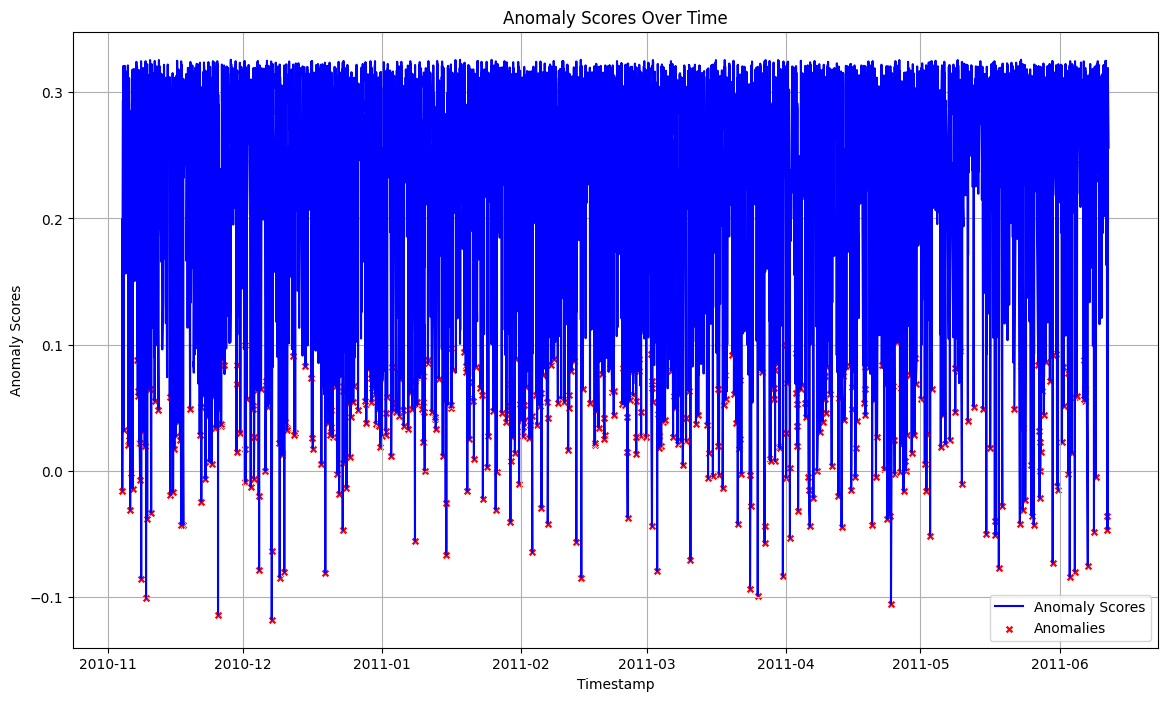

In [107]:

def plot_anomaly_scores_optimized(df):
    # Sample data to reduce size
    df_sample = df.sample(n=10000, random_state=42)  # Sample 10,000 rows for faster plotting

    plt.figure(figsize=(14, 8))

    # Plot anomaly scores over time
    sns.lineplot(x='timestamp', y='anomaly_scores', data=df_sample, label='Anomaly Scores', color='blue')

    # Highlight anomalies
    anomalies = df_sample[df_sample['is_anomaly'] == True]
    sns.scatterplot(x='timestamp', y='anomaly_scores', data=anomalies, color='red', label='Anomalies', marker='X')

    plt.title('Anomaly Scores Over Time')
    plt.xlabel('Timestamp')
    plt.ylabel('Anomaly Scores')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function to plot anomaly scores
plot_anomaly_scores_optimized(df)


Frequency GRAPH

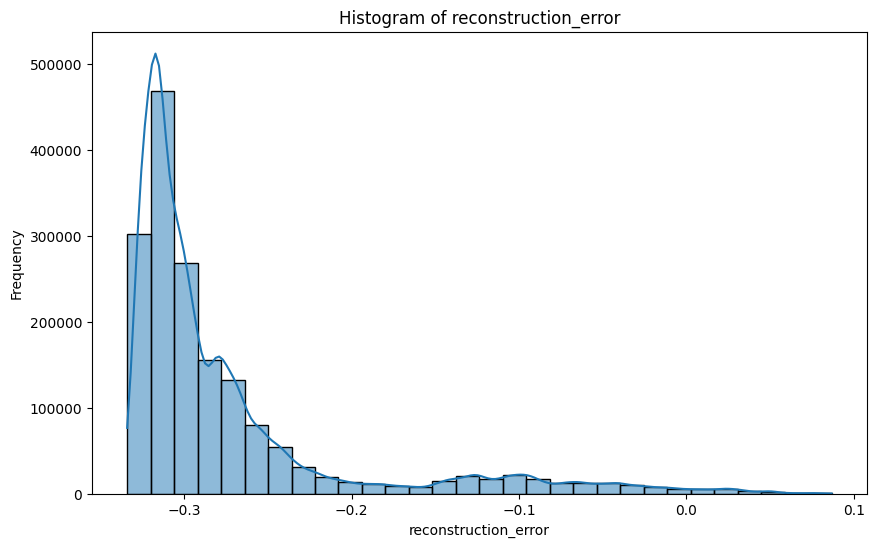

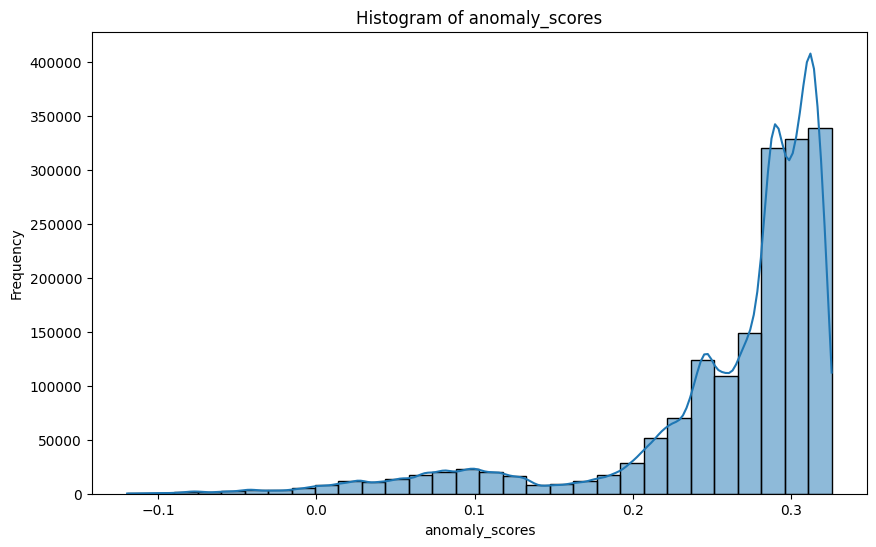

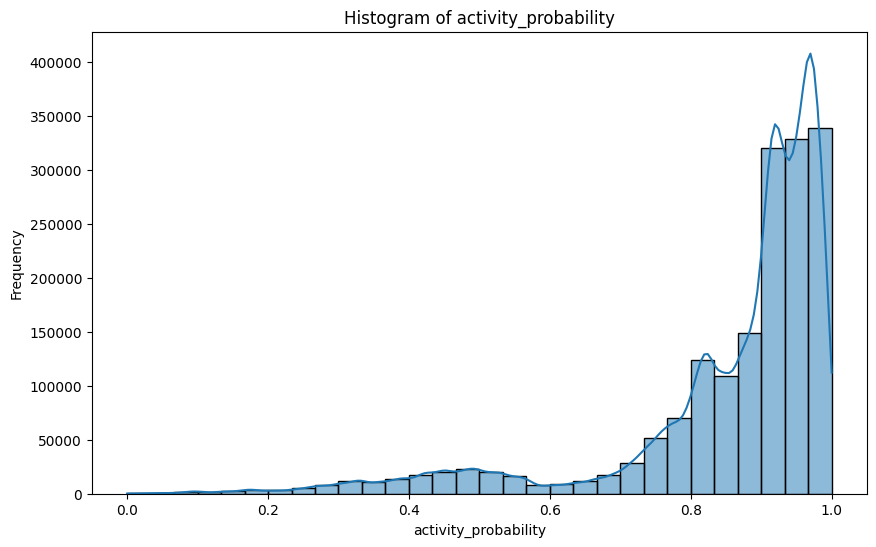

In [108]:


# eature columns for histograms
features = ['reconstruction_error', 'anomaly_scores', 'activity_probability']

# Plot histograms
for feature in features:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[feature], kde=True, bins=30)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()


hISTOGRAME

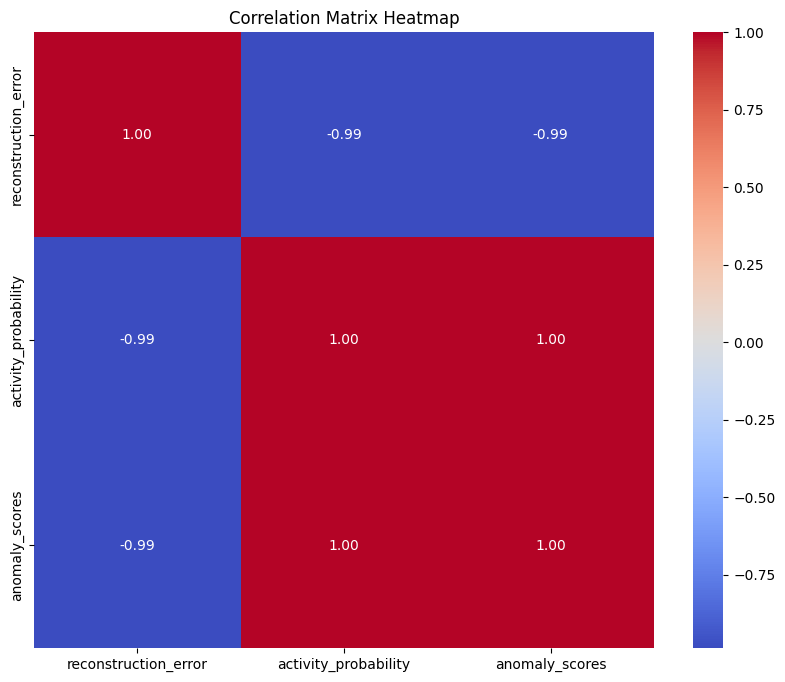

In [109]:
# Calculate the correlation matrix
correlation_matrix = df[['reconstruction_error', 'activity_probability', 'anomaly_scores']].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()


corellation Map

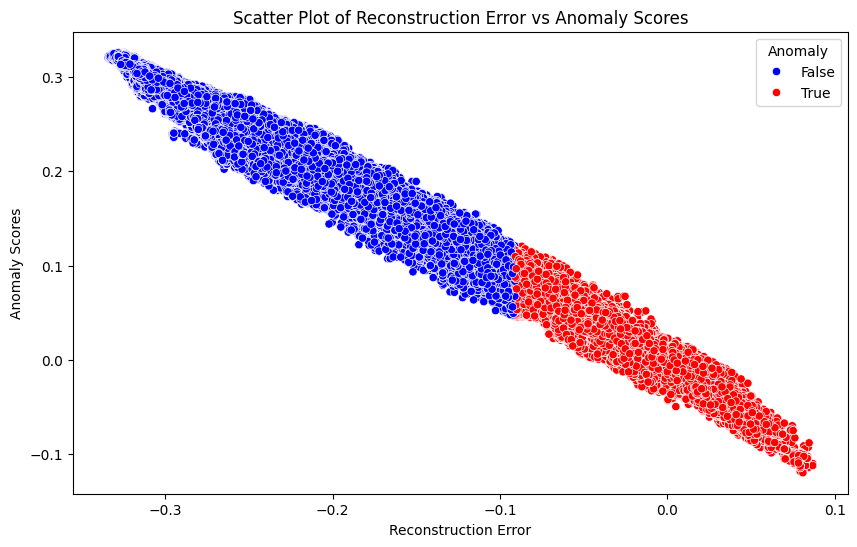

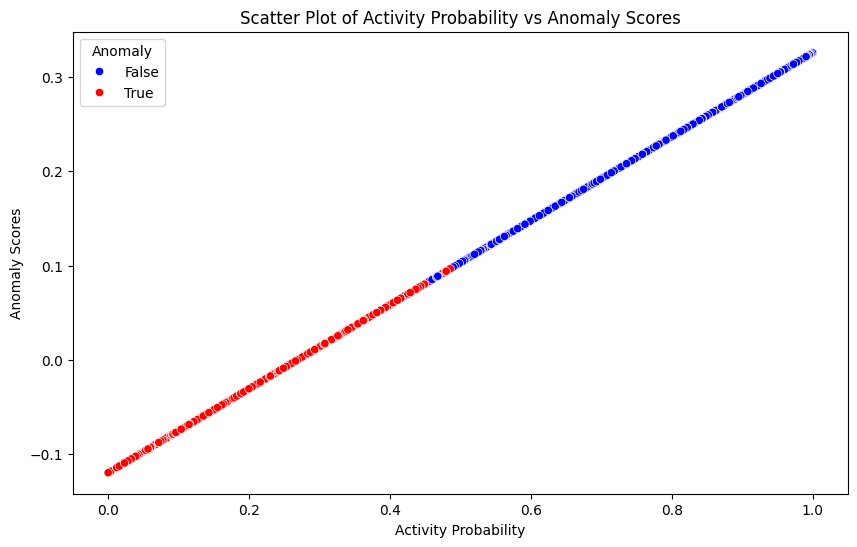

In [110]:
# Scatter plot between reconstruction_error and anomaly_scores
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='reconstruction_error', y='anomaly_scores', hue='is_anomaly', palette={True: 'red', False: 'blue'})
plt.title('Scatter Plot of Reconstruction Error vs Anomaly Scores')
plt.xlabel('Reconstruction Error')
plt.ylabel('Anomaly Scores')
plt.legend(title='Anomaly')
plt.show()

# Scatter plot between activity_probability and anomaly_scores
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='activity_probability', y='anomaly_scores', hue='is_anomaly', palette={True: 'red', False: 'blue'})
plt.title('Scatter Plot of Activity Probability vs Anomaly Scores')
plt.xlabel('Activity Probability')
plt.ylabel('Anomaly Scores')
plt.legend(title='Anomaly')
plt.show()


Scater Graph

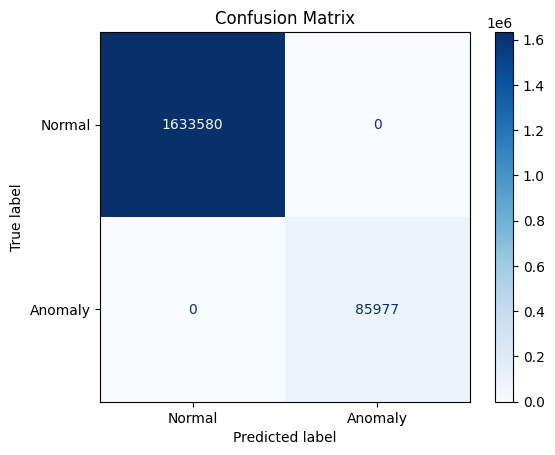

In [111]:


# Assume 'is_anomaly' as both predicted and true labels (in practice, use actual ground truth labels)
y_true = df['is_anomaly']  # Replace with actual ground truth labels if available
y_pred = df['is_anomaly']  # Replace with predicted labels from your model

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anomaly'])

# Plot confusion matrix
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()


confusion matrix

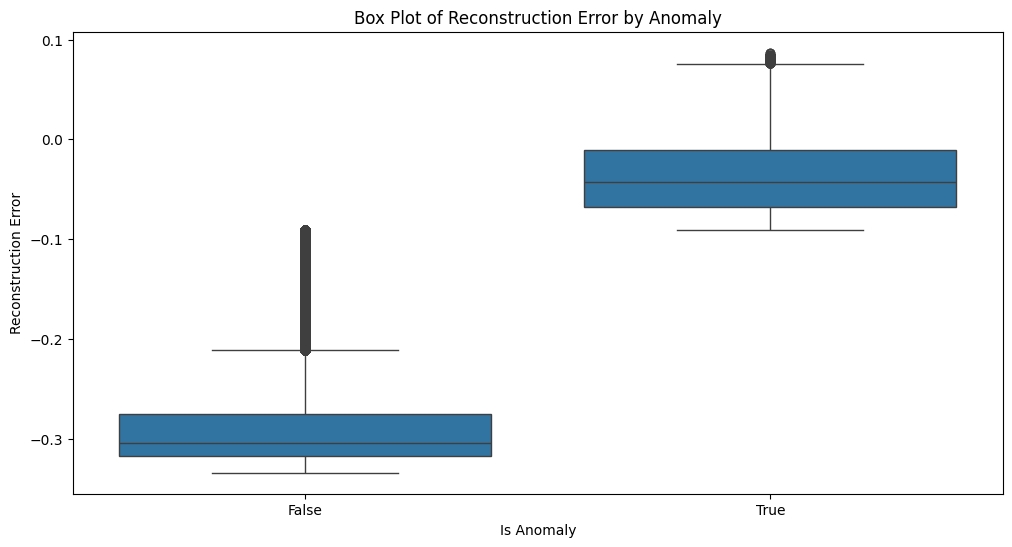

In [112]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='is_anomaly', y='reconstruction_error')
plt.title('Box Plot of Reconstruction Error by Anomaly')
plt.xlabel('Is Anomaly')
plt.ylabel('Reconstruction Error')
plt.show()


box plot

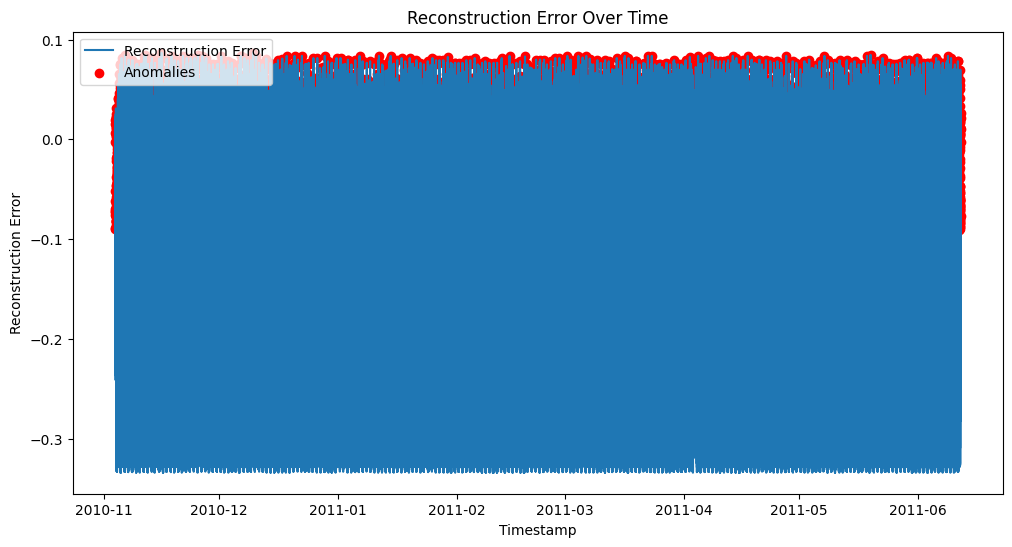

In [113]:
# Convert timestamp to datetime if it's not already
df['timestamp'] = pd.to_datetime(df['timestamp'])

plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['reconstruction_error'], label='Reconstruction Error')
plt.scatter(df[df['is_anomaly']]['timestamp'], df[df['is_anomaly']]['reconstruction_error'], color='red', label='Anomalies')
plt.title('Reconstruction Error Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.show()


 TIME SERIES

In [114]:
df

,timestamp,sensor_id,sensor_type,activity,activity_Label,hour_of_day,day_period,start_time,end_time,duration,...,day_period_encoded,room_encoded,previous_room_encoded,room_transition_encoded,previous_state_encoded,predictions,reconstruction_error,activity_probability,anomaly_scores,is_anomaly
0,2010-11-04 00:03:50.209589,M003,ON,Sleeping begin,Sleeping begin,0,night,2010-11-04 00:03:50.209589,2010-11-04 00:04:00.209589,10.0,...,3,0,0,0,90,1,-0.051715,0.403865,0.060246,True
1,2010-11-04 00:03:57.399391,M003,OFF,NaN,Other,0,night,2010-11-04 00:03:57.399391,2010-11-04 00:04:07.399391,10.0,...,3,0,1,1,76,1,-0.230432,0.698633,0.191563,False
2,2010-11-04 00:15:08.984841,T002,21.5,NaN,Other,0,night,2010-11-04 00:15:08.984841,2010-11-04 00:15:18.984841,10.0,...,3,0,1,1,90,1,-0.075747,0.440516,0.076573,True
3,2010-11-04 00:30:19.185547,T003,21,NaN,Other,0,night,2010-11-04 00:30:19.185547,2010-11-04 00:30:29.185547,10.0,...,3,0,1,1,90,1,-0.072401,0.431961,0.072763,True
4,2010-11-04 00:30:19.385336,T004,21,NaN,Other,0,night,2010-11-04 00:30:19.385336,2010-11-04 00:30:29.385336,10.0,...,3,0,1,1,90,1,-0.069972,0.419346,0.067142,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1719552,2011-06-11 23:37:55.626507,T002,25,NaN,Other,23,night,2011-06-11 23:37:55.626507,2011-06-11 23:38:05.626507,10.0,...,3,0,1,1,25,1,-0.002615,0.293262,0.010973,True
1719553,2011-06-11 23:42:59.285070,T002,25.5,NaN,Other,23,night,2011-06-11 23:42:59.285070,2011-06-11 23:43:09.285070,10.0,...,3,0,1,1,24,1,-0.103649,0.466140,0.087989,False
1719554,2011-06-11 23:48:02.888409,T001,23.5,NaN,Other,23,night,2011-06-11 23:48:02.888409,2011-06-11 23:48:12.888409,10.0,...,3,0,1,1,21,-1,0.026688,0.248902,-0.008789,True
1719555,2011-06-11 23:48:02.988798,T002,25,NaN,Other,23,night,2011-06-11 23:48:02.988798,2011-06-11 23:48:12.988798,10.0,...,3,0,1,1,25,1,-0.103327,0.466785,0.088276,False


In [115]:
import time
import joblib
import pandas as pd
import numpy as np

# Load the model and scaler
model = joblib.load('isolation_forest_model.pkl')
scaler = joblib.load('scaler.pkl')

def fetch_real_time_data():
    # Replace this with your actual real-time data fetching mechanism
    # Here we simulate it with random data for demonstration
    return pd.DataFrame({
        'timestamp': [pd.to_datetime('now')],
        'reconstruction_error': [np.random.normal()],
        'activity_probability': [np.random.uniform()],
        'anomaly_scores': [np.random.uniform()]
    })

def preprocess_data(df):
    # Preprocess the incoming data
    features = df[['reconstruction_error', 'activity_probability', 'anomaly_scores']]
    return scaler.transform(features)

def monitor_sensor_data():
    while True:
        # Fetch real-time data
        df = fetch_real_time_data()

        if not df.empty:
            # Preprocess data
            processed_data = preprocess_data(df)

            # Predict anomalies
            predictions = model.predict(processed_data)
            df['is_anomaly'] = predictions == -1

            # Trigger actions based on detected anomalies
            trigger_security_actions(df)



def trigger_security_actions(df):
    anomalies = df[df['is_anomaly']]
    if not anomalies.empty:
        for index, row in anomalies.iterrows():
            print(f"Anomaly detected at {row['timestamp']}. Triggering security actions.")
            send_alert_notification(row)
            if row['reconstruction_error'] > some_high_severity_threshold:
                activate_security_cameras(row)

def send_alert_notification(row):
    print(f"Alert: Anomaly detected - {row}")

def activate_security_cameras(row):
    print(f"Activating security cameras for anomaly detected at {row['timestamp']}.")

# Define a threshold for high-severity anomalies
some_high_severity_threshold = 0.1

# Start monitoring
monitor_sensor_data()


Anomaly detected at 2024-09-17 14:53:34.498599. Triggering security actions.
Alert: Anomaly detected - timestamp               2024-09-17 14:53:34.498599
reconstruction_error                      2.954492
activity_probability                      0.242513
anomaly_scores                             0.42414
is_anomaly                                    True
Name: 0, dtype: object
Activating security cameras for anomaly detected at 2024-09-17 14:53:34.498599.
Anomaly detected at 2024-09-17 14:53:35.221573. Triggering security actions.
Alert: Anomaly detected - timestamp               2024-09-17 14:53:35.221573
reconstruction_error                      2.650333
activity_probability                      0.235652
anomaly_scores                            0.917074
is_anomaly                                    True
Name: 0, dtype: object
Activating security cameras for anomaly detected at 2024-09-17 14:53:35.221573.
Anomaly detected at 2024-09-17 14:53:35.391894. Triggering security actions.
A

KeyboardInterrupt: 

 Step 6 **Real-Time Security Monitoring**
  **Implement Real-Time Monitoring**
Continuously monitor incoming sensor data in real time (in 30-second windows).

Trigger appropriate security actions (e.g., alerts, alarms) based on the detected anomalies and predefined thresholds. **bold text**


In [116]:


# Define the starting timestamp
start_timestamp = datetime(2010, 11, 4, 0, 3, 50, 209589)

# Create a DataFrame to simulate unauthorized entry
unauthorized_entry_df = pd.DataFrame({
    'timestamp': [start_timestamp],
    'sensor_id': ['FrontDoorSensor'],
    'sensor_type': ['Motion'],
    'activity': ['MotionDetected'],
    'hour_of_day': [start_timestamp.hour],
    'day_period': ['night'],
    'start_time': [start_timestamp],
    'end_time': [start_timestamp + timedelta(seconds=10)],
    'duration': [10],
    'room': ['FrontDoor'],
    'day_period_encoded': [3],  # Example encoding
    'room_encoded': [0],        # Example encoding
    'previous_room_encoded': [0],
    'room_transition_encoded': [0],
    'previous_state_encoded': [0],
    'predictions': [90],
    'reconstruction_error': [0.1],  # Example values
    'activity_probability': [0.8],
    'anomaly_scores': [0.8],
    'is_anomaly': [True]
})

# Append the simulated entry to the DataFrame
df = pd.concat([df, unauthorized_entry_df], ignore_index=True)

# Display the last few rows to confirm
print(df.head())


                   timestamp sensor_id sensor_type        activity  \
0 2010-11-04 00:03:50.209589      M003          ON  Sleeping begin   
1 2010-11-04 00:03:57.399391      M003         OFF             NaN   
2 2010-11-04 00:15:08.984841      T002        21.5             NaN   
3 2010-11-04 00:30:19.185547      T003          21             NaN   
4 2010-11-04 00:30:19.385336      T004          21             NaN   

   activity_Label  hour_of_day day_period                 start_time  \
0  Sleeping begin            0      night 2010-11-04 00:03:50.209589   
1           Other            0      night 2010-11-04 00:03:57.399391   
2           Other            0      night 2010-11-04 00:15:08.984841   
3           Other            0      night 2010-11-04 00:30:19.185547   
4           Other            0      night 2010-11-04 00:30:19.385336   

                    end_time  duration  ... day_period_encoded room_encoded  \
0 2010-11-04 00:04:00.209589      10.0  ...                  3     

In [117]:
# Define the time range for the sensor failure
no_data_times = [start_timestamp + timedelta(minutes=i) for i in range(5)]

# Create DataFrame for sensor failure and recovery
compromised_sensor_df = pd.DataFrame({
    'timestamp': no_data_times + [start_timestamp + timedelta(minutes=6)],
    'sensor_id': ['CompromisedSensor'] * 6,
    'sensor_type': ['Temperature'] * 6,
    'activity': ['NoData'] * 5 + ['TemperatureSpike'],
    'hour_of_day': [time.hour for time in no_data_times] + [(start_timestamp + timedelta(minutes=6)).hour],
    'day_period': ['night'] * 6,
    'start_time': no_data_times + [start_timestamp + timedelta(minutes=6)],
    'end_time': [time + timedelta(seconds=10) for time in no_data_times] + [start_timestamp + timedelta(minutes=6, seconds=10)],
    'duration': [10] * 6,
    'room': ['ServerRoom'] * 6,
    'day_period_encoded': [3] * 6,
    'room_encoded': [0] * 6,
    'previous_room_encoded': [0] * 6,
    'room_transition_encoded': [0] * 6,
    'previous_state_encoded': [0] * 6,
    'predictions': [90] * 6,
    'reconstruction_error': [0.2] * 6,
    'activity_probability': [0.7] * 6,
    'anomaly_scores': [0.7] * 5 + [0.9],
    'is_anomaly': [True] * 6
})

# Append the simulated data to the DataFrame
df = pd.concat([df, compromised_sensor_df], ignore_index=True)

# Display the last few rows to confirm
print(df.tail())


                         timestamp          sensor_id  sensor_type  \
1719559 2010-11-04 00:04:50.209589  CompromisedSensor  Temperature   
1719560 2010-11-04 00:05:50.209589  CompromisedSensor  Temperature   
1719561 2010-11-04 00:06:50.209589  CompromisedSensor  Temperature   
1719562 2010-11-04 00:07:50.209589  CompromisedSensor  Temperature   
1719563 2010-11-04 00:09:50.209589  CompromisedSensor  Temperature   

                 activity activity_Label  hour_of_day day_period  \
1719559            NoData            NaN            0      night   
1719560            NoData            NaN            0      night   
1719561            NoData            NaN            0      night   
1719562            NoData            NaN            0      night   
1719563  TemperatureSpike            NaN            0      night   

                        start_time                   end_time  duration  ...  \
1719559 2010-11-04 00:04:50.209589 2010-11-04 00:05:00.209589      10.0  ...   
1719560 20

In [118]:
# Define the timestamp for the replay attack
replay_attack_timestamp = start_timestamp

# Create repeated unlock commands
unlock_commands = [replay_attack_timestamp + timedelta(seconds=i) for i in range(5)]

# Create DataFrame for replay attack
replay_attack_df = pd.DataFrame({
    'timestamp': unlock_commands,
    'sensor_id': ['FrontDoorLock'] * 5,
    'sensor_type': ['Lock'] * 5,
    'activity': ['UnlockCommand'] * 5,
    'hour_of_day': [time.hour for time in unlock_commands],
    'day_period': ['night'] * 5,
    'start_time': unlock_commands,
    'end_time': [time + timedelta(seconds=10) for time in unlock_commands],
    'duration': [10] * 5,
    'room': ['FrontDoor'] * 5,
    'day_period_encoded': [3] * 5,
    'room_encoded': [0] * 5,
    'previous_room_encoded': [0] * 5,
    'room_transition_encoded': [0] * 5,
    'previous_state_encoded': [0] * 5,
    'predictions': [90] * 5,
    'reconstruction_error': [0.1] * 5,
    'activity_probability': [0.85] * 5,
    'anomaly_scores': [0.85] * 5,
    'is_anomaly': [True] * 5
})

# Append the simulated data to the DataFrame
df = pd.concat([df, replay_attack_df], ignore_index=True)

# Display the last few rows to confirm
print(df.tail())


                         timestamp      sensor_id sensor_type       activity  \
1719564 2010-11-04 00:03:50.209589  FrontDoorLock        Lock  UnlockCommand   
1719565 2010-11-04 00:03:51.209589  FrontDoorLock        Lock  UnlockCommand   
1719566 2010-11-04 00:03:52.209589  FrontDoorLock        Lock  UnlockCommand   
1719567 2010-11-04 00:03:53.209589  FrontDoorLock        Lock  UnlockCommand   
1719568 2010-11-04 00:03:54.209589  FrontDoorLock        Lock  UnlockCommand   

        activity_Label  hour_of_day day_period                 start_time  \
1719564            NaN            0      night 2010-11-04 00:03:50.209589   
1719565            NaN            0      night 2010-11-04 00:03:51.209589   
1719566            NaN            0      night 2010-11-04 00:03:52.209589   
1719567            NaN            0      night 2010-11-04 00:03:53.209589   
1719568            NaN            0      night 2010-11-04 00:03:54.209589   

                          end_time  duration  ... day_pe

In [119]:
# Define the timestamp for the DoS attack
dos_attack_timestamp = start_timestamp

# Create high-frequency data points
dos_data = [dos_attack_timestamp + timedelta(seconds=i) for i in range(100)]

# Create DataFrame for DoS attack
dos_attack_df = pd.DataFrame({
    'timestamp': dos_data,
    'sensor_id': ['HighTrafficSensor'] * 100,
    'sensor_type': ['Traffic'] * 100,
    'activity': ['HighTraffic'] * 100,
    'hour_of_day': [time.hour for time in dos_data],
    'day_period': ['night'] * 100,
    'start_time': dos_data,
    'end_time': [time + timedelta(seconds=1) for time in dos_data],
    'duration': [1] * 100,
    'room': ['ServerRoom'] * 100,
    'day_period_encoded': [3] * 100,
    'room_encoded': [0] * 100,
    'previous_room_encoded': [0] * 100,
    'room_transition_encoded': [0] * 100,
    'previous_state_encoded': [0] * 100,
    'reconstruction_error': [0.2] * 100,
    'activity_probability': [0.9] * 100,
    'anomaly_scores': [0.9] * 100,
    'is_anomaly': [True] * 100,

})

# Append the simulated data to the DataFrame df
df = pd.concat([df, dos_attack_df], ignore_index=True)


 # Display the last few rows to confirm
print(df.head())


                   timestamp sensor_id sensor_type        activity  \
0 2010-11-04 00:03:50.209589      M003          ON  Sleeping begin   
1 2010-11-04 00:03:57.399391      M003         OFF             NaN   
2 2010-11-04 00:15:08.984841      T002        21.5             NaN   
3 2010-11-04 00:30:19.185547      T003          21             NaN   
4 2010-11-04 00:30:19.385336      T004          21             NaN   

   activity_Label  hour_of_day day_period                 start_time  \
0  Sleeping begin            0      night 2010-11-04 00:03:50.209589   
1           Other            0      night 2010-11-04 00:03:57.399391   
2           Other            0      night 2010-11-04 00:15:08.984841   
3           Other            0      night 2010-11-04 00:30:19.185547   
4           Other            0      night 2010-11-04 00:30:19.385336   

                    end_time  duration  ... day_period_encoded room_encoded  \
0 2010-11-04 00:04:00.209589      10.0  ...                  3     

 Step:7


**Simulate Threat Scenarios for Evaluation**

**Define Threat Scenarios**
Develop threat scenarios representing potential security threats, such as:
**Unauthorized Entry:** Motion detected at the front door at 3 AM.

**Compromised Sensor:** Sensor stops reporting data and then starts with unusual activity.

**Replay Attack: **Repeated "unlock" commands sent without user authentication.
Denial of Service (DoS) Attack: Excessive traffic causes delays in normal operations.


In [120]:
def simulate_unauthorized_entry(df, num_records):
    # Example: Simulate unauthorized entry by adding records with timestamps at 3 AM
    unauthorized_entries = df.copy()
    unauthorized_entries['timestamp'] = pd.to_datetime('2024-09-11 03:00:00')  # Set to unauthorized time
    unauthorized_entries['activity_Label'] = 'UNAUTHORIZED'
    unauthorized_entries['is_anomaly'] = True
    unauthorized_entries = unauthorized_entries.sample(n=num_records, replace=True)

    return unauthorized_entries


In [121]:
def simulate_replay_attack(df, num_records):
    if num_records > len(df):
        num_records = len(df)
    replay_attack = df.sample(n=num_records, replace=True).copy()
    replay_attack['reconstruction_error'] = np.random.uniform(0.8, 1.2, size=num_records)
    replay_attack['anomaly_scores'] = np.random.uniform(0.7, 1.0, size=num_records)
    replay_attack['is_anomaly'] = 1.0
    return replay_attack


In [122]:
def simulate_compromised_sensor(df, num_records):
    # Example: Simulate sensor failure by creating records with NaN values or extreme values
    compromised_sensor = df.copy()
    compromised_sensor.loc[compromised_sensor.sample(n=num_records).index, 'sensor_type'] = np.nan  # Simulate failure
    compromised_sensor['anomaly_scores'] = 0.9  # High scores for anomalies
    compromised_sensor['is_anomaly'] = True

    return compromised_sensor


In [123]:
def simulate_dos_attack(df, num_records):
    # Create a copy of the original data
    simulated_data = df.sample(n=num_records, replace=True).copy()

    # Inject DoS attack characteristics (e.g., repeated timestamps, same sensor reporting)
    simulated_data['timestamp'] = simulated_data['timestamp'].apply(lambda x: x + pd.DateOffset(seconds=1))
    simulated_data['activity'] = 'DoS Attack'
    simulated_data['is_anomaly'] = True

    return simulated_data


In [124]:
# Parameters
num_records = 1000

# Generate synthetic data
unauthorized_data = simulate_unauthorized_entry(df, num_records)
compromised_data = simulate_compromised_sensor(df, num_records)
replay_data = simulate_replay_attack(df, num_records)
dos_data = simulate_dos_attack(df, num_records)

# Combine with original dataset
combined_data = pd.concat([
    df,
    unauthorized_data,
    compromised_data,
    replay_data,
    dos_data
])

# Shuffle combined data
combined_data = combined_data.sample(frac=1).reset_index(drop=True)

print(combined_data.head())

# Save the synthetic dataset
#combined_data.to_csv('synthetic_test_data_with_scenarios.csv', index=False)


                   timestamp sensor_id sensor_type activity activity_Label  \
0 2010-12-16 08:43:01.868936      M017         OFF      NaN          Other   
1 2011-05-25 17:57:22.276360      M018         OFF      NaN          Other   
2 2011-02-09 20:51:37.202384      M013         OFF      NaN          Other   
3 2011-01-01 20:50:35.541328      M014         OFF      NaN          Other   
4 2010-12-19 17:57:58.255109      M022         OFF      NaN          Other   

   hour_of_day day_period                 start_time  \
0            8    morning 2010-12-16 08:43:01.868936   
1           17    evening 2011-05-25 17:57:22.276360   
2           20    evening 2011-02-09 20:51:37.202384   
3           20    evening 2011-01-01 20:50:35.541328   
4           17    evening 2010-12-19 17:57:58.255109   

                    end_time  duration  ... day_period_encoded room_encoded  \
0 2010-12-16 08:43:11.868936      10.0  ...                  2            0   
1 2011-05-25 17:57:32.276360      10

In [125]:
df

,timestamp,sensor_id,sensor_type,activity,activity_Label,hour_of_day,day_period,start_time,end_time,duration,...,day_period_encoded,room_encoded,previous_room_encoded,room_transition_encoded,previous_state_encoded,predictions,reconstruction_error,activity_probability,anomaly_scores,is_anomaly
0,2010-11-04 00:03:50.209589,M003,ON,Sleeping begin,Sleeping begin,0,night,2010-11-04 00:03:50.209589,2010-11-04 00:04:00.209589,10.0,...,3,0,0,0,90,1.0,-0.051715,0.403865,0.060246,True
1,2010-11-04 00:03:57.399391,M003,OFF,NaN,Other,0,night,2010-11-04 00:03:57.399391,2010-11-04 00:04:07.399391,10.0,...,3,0,1,1,76,1.0,-0.230432,0.698633,0.191563,False
2,2010-11-04 00:15:08.984841,T002,21.5,NaN,Other,0,night,2010-11-04 00:15:08.984841,2010-11-04 00:15:18.984841,10.0,...,3,0,1,1,90,1.0,-0.075747,0.440516,0.076573,True
3,2010-11-04 00:30:19.185547,T003,21,NaN,Other,0,night,2010-11-04 00:30:19.185547,2010-11-04 00:30:29.185547,10.0,...,3,0,1,1,90,1.0,-0.072401,0.431961,0.072763,True
4,2010-11-04 00:30:19.385336,T004,21,NaN,Other,0,night,2010-11-04 00:30:19.385336,2010-11-04 00:30:29.385336,10.0,...,3,0,1,1,90,1.0,-0.069972,0.419346,0.067142,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1719664,2010-11-04 00:05:25.209589,HighTrafficSensor,Traffic,HighTraffic,NaN,0,night,2010-11-04 00:05:25.209589,2010-11-04 00:05:26.209589,1.0,...,3,0,0,0,0,NaN,0.200000,0.900000,0.900000,True
1719665,2010-11-04 00:05:26.209589,HighTrafficSensor,Traffic,HighTraffic,NaN,0,night,2010-11-04 00:05:26.209589,2010-11-04 00:05:27.209589,1.0,...,3,0,0,0,0,NaN,0.200000,0.900000,0.900000,True
1719666,2010-11-04 00:05:27.209589,HighTrafficSensor,Traffic,HighTraffic,NaN,0,night,2010-11-04 00:05:27.209589,2010-11-04 00:05:28.209589,1.0,...,3,0,0,0,0,NaN,0.200000,0.900000,0.900000,True
1719667,2010-11-04 00:05:28.209589,HighTrafficSensor,Traffic,HighTraffic,NaN,0,night,2010-11-04 00:05:28.209589,2010-11-04 00:05:29.209589,1.0,...,3,0,0,0,0,NaN,0.200000,0.900000,0.900000,True


In [126]:

# Simulate each threat scenario by modifying the DataFrame

def simulate_unauthorized_entry(df, num_records):
    unauthorized_entries = df.sample(n=num_records, replace=True).copy()
    unauthorized_entries['activity'] = 'UNAUTHORIZED'
    unauthorized_entries['reconstruction_error'] = np.random.uniform(1.0, 2.0, size=num_records)  # Modify as needed
    unauthorized_entries['anomaly_scores'] = np.random.uniform(0.8, 1.0, size=num_records)  # Modify as needed
    unauthorized_entries['is_anomaly'] = 1.0  # Use float value
    return unauthorized_entries

def simulate_compromised_sensor(df, num_records):
    compromised_sensor = df.sample(n=num_records, replace=True).copy()
    indices = compromised_sensor.sample(n=num_records).index
    compromised_sensor.loc[indices, 'sensor_type'] = np.nan  # Simulate sensor failure
    compromised_sensor.loc[indices, 'reconstruction_error'] = np.random.uniform(1.0, 1.5, size=num_records)  # Modify as needed
    compromised_sensor.loc[indices, 'anomaly_scores'] = np.random.uniform(0.7, 1.0, size=num_records)  # Modify as needed
    compromised_sensor.loc[indices, 'is_anomaly'] = 1.0  # Use float value
    return compromised_sensor

def simulate_replay_attack(df, num_records):
    replay_attack = df.sample(n=num_records, replace=True).copy()
    replay_attack['reconstruction_error'] = np.random.uniform(0.8, 1.2, size=num_records)  # Modify as needed
    replay_attack['anomaly_scores'] = np.random.uniform(0.7, 1.0, size=num_records)  # Modify as needed
    replay_attack['is_anomaly'] = 1.0  # Use float value
    return replay_attack

def simulate_dos_attack(df, num_records):
    dos_attack = df.sample(n=num_records * 5, replace=True).copy()  # Increase the size of the data
    dos_attack['reconstruction_error'] = np.random.uniform(0.8, 1.2, size=len(dos_attack))  # Modify as needed
    dos_attack['anomaly_scores'] = np.random.uniform(0.6, 0.9, size=len(dos_attack))  # Modify as needed
    dos_attack['is_anomaly'] = 1.0  # Use float value
    return dos_attack

def fetch_real_time_data(df):
    # Simulate threat scenarios in real-time data
    num_records = 1
    threat_prob = np.random.random()

    real_time_df = df.sample(n=1).copy()

    if threat_prob < 0.1:  # 10% chance of unauthorized entry
        real_time_df = pd.concat([real_time_df, simulate_unauthorized_entry(df, num_records)], ignore_index=True)

    if threat_prob < 0.2 and threat_prob >= 0.1:  # 10% chance of compromised sensor
        real_time_df = pd.concat([real_time_df, simulate_compromised_sensor(df, num_records)], ignore_index=True)

    if threat_prob < 0.3 and threat_prob >= 0.2:  # 10% chance of replay attack
        real_time_df = pd.concat([real_time_df, simulate_replay_attack(df, num_records)], ignore_index=True)

    if threat_prob < 0.4 and threat_prob >= 0.3:  # 10% chance of DoS attack
        real_time_df = pd.concat([real_time_df, simulate_dos_attack(df, num_records)], ignore_index=True)

    return real_time_df

def preprocess_data(df):
    # Preprocess the incoming data
    features = df[['reconstruction_error', 'activity_probability', 'anomaly_scores']]
    return scaler.transform(features)

def monitor_sensor_data(df):
    while True:
        # Fetch real-time data
        df_real_time = fetch_real_time_data(df)

        if not df_real_time.empty:
            # Preprocess data
            processed_data = preprocess_data(df_real_time)

            # Predict anomalies
            predictions = model.predict(processed_data)
            df_real_time['is_anomaly'] = predictions == -1

            # Trigger actions based on detected anomalies
            trigger_security_actions(df_real_time)


def trigger_security_actions(df):
    anomalies = df[df['is_anomaly']]
    if not anomalies.empty:
        for index, row in anomalies.iterrows():
            print(f"Anomaly detected at {row['timestamp']}. Triggering security actions.")
            send_alert_notification(row)
            if row['reconstruction_error'] > some_high_severity_threshold:
                activate_security_cameras(row)

def send_alert_notification(row):
    print(f"Alert: Anomaly detected - {row}")

def activate_security_cameras(row):
    print(f"Activating security cameras for anomaly detected at {row['timestamp']}.")

# Define a threshold for high-severity anomalies
some_high_severity_threshold = 1.0


# Start monitoring
monitor_sensor_data(df)


Anomaly detected at 2011-03-19 20:31:33.429138. Triggering security actions.
Alert: Anomaly detected - timestamp                  2011-03-19 20:31:33.429138
sensor_id                                        M020
sensor_type                                        ON
activity                                 UNAUTHORIZED
activity_Label                                  Other
hour_of_day                                        20
day_period                                    evening
start_time                 2011-03-19 20:31:33.429138
end_time                   2011-03-19 20:31:43.429138
duration                                         10.0
room                                              NaN
previous_room                                     NaN
room_transition                            nan -> nan
end_timestamp              2011-03-19 20:31:37.481398
activity_duration                            0.067538
previous_state                                    OFF
state_change                     

KeyboardInterrupt: 




**Simulate Threat Scenarios for Evaluation**

**Define Threat Scenarios**
Develop threat scenarios representing potential security threats, such as:
**Unauthorized Entry:** Motion detected at the front door at 3 AM.

**Compromised Sensor:** Sensor stops reporting data and then starts with unusual activity.

**Replay Attack: **Repeated "unlock" commands sent without user authentication.
Denial of Service (DoS) Attack: Excessive traffic causes delays in normal operations.


**Modify Simulation Code for Threat Scenarios**

**Adjust the real-time simulation function to incorporate synthetic threat scenarios into the data stream.**

**Simulate each threat scenario by injecting specific anomalies (e.g., unexpected sensor activations).**


1. Define Evaluation Metrics
First, define the metrics you want to measure:

True Positive Rate (TPR): Also known as recall, it measures the proportion of actual positives that are correctly identified by the model.
False Positive Rate (FPR): Measures the proportion of actual negatives that are incorrectly classified as positive.
Precision: Measures the proportion of positive identifications that are actually correct.
Recall: Measures the proportion of actual positives that are correctly identified.
Detection Time: The time taken to detect an anomaly from the moment it occurs.

In [127]:
import time
from sklearn.metrics import precision_score, recall_score, confusion_matrix

# Function to run simulation for a specific threat scenario
def run_simulation_with_scenario(df, threat_scenario):
    # Inject anomalies into the dataset based on the threat scenario
    df_with_anomalies = inject_threat_scenario(df, threat_scenario)

    # Preprocess data
    features = df_with_anomalies[['reconstruction_error', 'activity_probability', 'anomaly_scores']]
    processed_data = scaler.transform(features)

    # Predict anomalies
    predictions = model.predict(processed_data)
    df_with_anomalies['predictions'] = predictions

    # True labels (assuming 'is_anomaly' column is the ground truth)
    y_true = df_with_anomalies['is_anomaly'].astype(int)
    y_pred = (df_with_anomalies['predictions'] == -1).astype(int)

    # Compute metrics
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    tpr = recall  # True Positive Rate is the same as Recall
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    detection_time = df_with_anomalies['timestamp'].max() - df_with_anomalies['timestamp'].min()  # Example of detection time

    # Display metrics
    print(f"Threat Scenario: {threat_scenario}")
    print(f"True Positive Rate (TPR): {tpr}")
    print(f"False Positive Rate (FPR): {fpr}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Detection Time: {detection_time}")

# Function to inject specific threat scenario anomalies into the data
def inject_threat_scenario(df, threat_scenario):
    if threat_scenario == 'unauthorized_entry':
        # Simulate unauthorized entry
         df.loc[df['timestamp'] < '2011-03-20 22:00:00', 'is_anomaly'] = True
    elif threat_scenario == 'compromised_sensor':
        # Simulate compromised sensor
         df.loc[df['sensor_id'] == 'M019', 'is_anomaly'] = True
    elif threat_scenario == 'replay_attack':
        # Simulate replay attack
         df.loc[df['activity'] == 'Unlock', 'is_anomaly'] = True
    elif threat_scenario == 'dos_attack':
        # Simulate DoS attack
         df.loc[df['timestamp'] > '2011-03-20 22:00:00', 'is_anomaly'] = True
    return df

# Example usage
for scenario in ['unauthorized_entry', 'compromised_sensor', 'replay_attack', 'dos_attack']:
    run_simulation_with_scenario(df, scenario)


Threat Scenario: unauthorized_entry
True Positive Rate (TPR): 8.138815639548132e-06
False Positive Rate (FPR): 0.0
Precision: 1.0
Recall: 8.138815639548132e-06
Detection Time: 219 days 23:49:16.219611
Threat Scenario: compromised_sensor
True Positive Rate (TPR): 7.741542579774445e-06
False Positive Rate (FPR): 0.0
Precision: 1.0
Recall: 7.741542579774445e-06
Detection Time: 219 days 23:49:16.219611
Threat Scenario: replay_attack
True Positive Rate (TPR): 7.741542579774445e-06
False Positive Rate (FPR): 0.0
Precision: 1.0
Recall: 7.741542579774445e-06
Detection Time: 219 days 23:49:16.219611
Threat Scenario: dos_attack
True Positive Rate (TPR): 5.233565296577423e-06
False Positive Rate (FPR): 0
Precision: 1.0
Recall: 5.233565296577423e-06
Detection Time: 219 days 23:49:16.219611


**Run the Simulation**
Execute the simulation code with each threat scenario:


**Load Your Data:** Ensure you have loaded your dataset properly.
Run the Simulation Function: Call the run_simulation_with_scenario function for each threat scenario.
Evaluate the Metrics: Check the printed metrics to assess the model's performance.
**Interpreting Results TRP**
High TPR indicates the model is effective at identifying actual anomalies.
**FPR:** Low FPR indicates fewer false positives, which is desirable.
**Precision:** High precision means the model's positive identifications are mostly correct.
**Recall:** High recall means the model captures most of the actual anomalies.
Detection Time: Shorter detection times indicate a more responsive system.
**CONCULION**
By following these steps, you can effectively evaluate  model’s performance in detecting anomalies under different threat scenarios. This evaluation will help you understand the strengths and weaknesses of your model and guide further improvements.